# Analyzing COVID-19 situation in Russia

* [Russia geo plotting notebook](https://www.kaggle.com/kapral42/covid-19-russia-geo-plotting)
* [Estimating COVID-19 Rt in Real-Time. Russia](https://www.kaggle.com/fo2rist/estimating-covid-19-rt-in-real-time-russia) Thanks [@fo2rist](https://www.kaggle.com/fo2rist) for contribution

# **Import**

In [1]:
# essential libraries
import json
import random
from urllib.request import urlopen

# storing and anaysis
import numpy as np
import pandas as pd
from scipy import stats as sps
from scipy.interpolate import interp1d

# visualization
import seaborn as sns
import plotly.express as px
import plotly.graph_objs as go
import plotly.figure_factory as ff
import folium

from matplotlib import pyplot as plt
from matplotlib.dates import date2num, num2date
from matplotlib import dates as mdates
from matplotlib import ticker
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch

# color pallette
cnf = '#393e46' # confirmed - grey
dth = '#ff2e63' # death - red
rec = '#21bf73' # recovered - cyan
act = '#fe9801' # active case - yellow
tst = '#2fb1d2' # tests - blue
ctl = '#e2e42e' # contrloed - yellow

# converter
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()   

# hide warnings
import warnings
warnings.filterwarnings('ignore')

# html embedding
from IPython.display import Javascript
from IPython.core.display import display
from IPython.core.display import HTML

# Dataset

* [Russia dataset](https://www.kaggle.com/kapral42/covid19-russia-regions-cases)

Read and prepare World data

In [2]:
# list files
# !ls ../input/novel-corona-virus-2019-dataset/

In [3]:
# Read data
all_confirmed_df = pd.read_csv('../input/novel-corona-virus-2019-dataset/time_series_covid_19_confirmed.csv')
all_deaths_df = pd.read_csv('../input/novel-corona-virus-2019-dataset/time_series_covid_19_deaths.csv')
all_recovered_df = pd.read_csv('../input/novel-corona-virus-2019-dataset/time_series_covid_19_recovered.csv')

In [4]:
# Merging tables

dates = all_confirmed_df.columns[4:]

all_confirmed_df_melt = all_confirmed_df.melt(id_vars=['Province/State', 'Country/Region', 'Lat', 'Long'], 
                                              value_vars=dates, var_name='Date', value_name='Confirmed')

all_deaths_df_melt = all_deaths_df.melt(id_vars=['Province/State', 'Country/Region', 'Lat', 'Long'], 
                                        value_vars=dates, var_name='Date', value_name='Deaths')

all_recovered_df_melt = all_recovered_df.melt(id_vars=['Province/State', 'Country/Region', 'Lat', 'Long'], 
                                              value_vars=dates, var_name='Date', value_name='Recovered')

world_cases_df = pd.concat([all_confirmed_df_melt, all_deaths_df_melt['Deaths'], all_recovered_df_melt['Recovered']], 
                       axis=1, sort=False)

# world_cases_df.head(10)

In [5]:
# cases 
cases = ['Confirmed', 'Deaths', 'Recovered', 'Active']

# Active Case = confirmed - deaths - recovered
world_cases_df['Active'] = world_cases_df['Confirmed'] - world_cases_df['Deaths'] - world_cases_df['Recovered']

# replacing Mainland china with just China
world_cases_df['Country/Region'] = world_cases_df['Country/Region'].replace('Mainland China', 'China')

# filling missing values 
world_cases_df[['Province/State']] = world_cases_df[['Province/State']].fillna('')
world_cases_df[cases] = world_cases_df[cases].fillna(0)
world_cases_df['Date'] = pd.to_datetime(world_cases_df['Date'])

Read and prepare Russian data

In [6]:
# !ls ../input/covid19-russia-regions-cases/

In [7]:
rus_df = pd.read_csv('../input/covid19-russia-regions-cases/covid19-russia-cases.csv')
rus_other_df = pd.read_csv('../input/covid19-russia-regions-cases/covid19-tests-and-other.csv')
rus_info_df = pd.read_csv('../input/covid19-russia-regions-cases/regions-info.csv')
rus_vent_df = pd.read_csv('../input/covid19-russia-regions-cases/regions-ventilators.csv')
iso_df = pd.read_csv('../input/covid19-russia-regions-cases/isolation_daily.csv')
mos_death_df = pd.read_csv('../input/covid19-russia-regions-cases/moscow_deaths.csv')

# Read R-value notebook output
rt_df = pd.read_csv('../input/estimating-covid-19-rt-in-real-time-russia/rt.csv')

In [8]:
rus_df['Date'] = pd.to_datetime(rus_df['Date'], dayfirst=True) 
print('Data actual date:', rus_df.iloc[-1]['Date'].strftime('%d, %b %Y'))

rus_df['Active'] = rus_df['Confirmed'] - rus_df['Deaths'] - rus_df['Recovered']
rus_df['Death_rate'] = rus_df['Deaths'] / rus_df['Confirmed'] * 100

# Remove Diamond Princess cases
rus_df = rus_df[rus_df['Region/City'] != 'Diamond Princess']

rt_df.date = pd.to_datetime(rt_df.date)
iso_df.Date = pd.to_datetime(iso_df.Date, dayfirst=True)

Data actual date: 27, May 2020


In [9]:
# Combining with regions info
right = rus_info_df[['Region_ID', 'Population']]
rus_df = rus_df.merge(right, left_on='Region_ID', right_on='Region_ID', how='left')
rus_df['Conf_p100k'] = rus_df.Confirmed / (rus_df.Population / 100000)
rus_df = rus_df.drop('Population', axis=1)

In [10]:
# Get current situation in regions
rus_latest = rus_df.groupby('Region/City').apply(lambda df: df.loc[df['Date'].idxmax()])
rus_latest = rus_latest.sort_values(by='Confirmed', ascending=False).reset_index(drop=True)
rus_latest = rus_latest[['Region/City'] + cases + ['Death_rate', 'Conf_p100k']]

# Region wise Data

In [11]:
rus_latest.style.background_gradient(cmap='Reds')

,Region/City,Confirmed,Deaths,Recovered,Active,Death_rate,Conf_p100k
0,Москва,171443,2183,67458,101802,1.27331,1350.75
1,Московская область,35956,359,6440,29157,0.998443,467.711
2,Санкт-Петербург,14463,158,4458,9847,1.09244,268.181
3,Нижегородская область,8735,78,2905,5752,0.892959,272.643
4,Республика Дагестан,4455,130,4161,164,2.91807,143.185
5,Свердловская область,4425,21,1700,2704,0.474576,102.648
6,Ростовская область,4133,34,1441,2658,0.822647,98.5144
7,Красноярский край,3700,29,791,2880,0.783784,129.015
8,Калужская область,3560,29,1123,2408,0.814607,355.975
9,Краснодарский край,3506,29,2257,1220,0.827153,61.7494


In [12]:
temp = rus_df.groupby(['Date', 'Region/City'])['Confirmed'].max().reset_index()
temp = temp.sort_values(['Confirmed', 'Date'], ascending=False)

px.line(temp, x="Date", y="Confirmed", color='Region/City', title='Cases Spread', height=600)

In [13]:
temp = rus_df.groupby(['Date', 'Region/City'])['Conf_p100k'].max().reset_index()
temp = temp.sort_values(['Conf_p100k', 'Date'], ascending=False)

fig = px.line(temp, x="Date", y="Conf_p100k", color='Region/City', title='Confirmed cases per 100 000 people', height=600)
fig.update_layout(yaxis_title='Confirmed per 100K')

In [14]:
temp = rus_df.groupby(['Date', 'Region/City'])[['Day-Confirmed', 'Confirmed']].max().reset_index()
temp = temp.sort_values(['Confirmed', 'Date'], ascending=False)

px.line(temp, x="Date", y="Day-Confirmed", color='Region/City', title='Daily confirmed cases spread', height=600)

In [15]:
top = 30
temp = rus_latest.loc[rus_latest.Death_rate > 0].sort_values('Death_rate', ascending=False).head(top)
temp = temp.sort_values('Death_rate').melt(id_vars="Region/City", value_vars=['Death_rate'])

fig = px.bar(temp, y="Region/City", x="value", color='variable', color_discrete_sequence=[dth, cnf], orientation='h')
fig.update_layout(barmode='group', title=f'The percentage of deaths from all confirmed cases - Top {top}',
                  xaxis_title='Death Rate', yaxis_title='', height=800)
fig.show()

In [16]:
# Copied function from "Estimating COVID-19 Rt in Real-Time. Russia" notebook
def plot_rt(result, ax, state_name):
    
    ax.set_title(f"{state_name}")
    
    # Colors
    ABOVE =  [1,0,0]
    MIDDLE = [1,1,1]
    BELOW =  [0,0,0]
    cmap = ListedColormap(np.r_[
        np.linspace(BELOW,MIDDLE,25),
        np.linspace(MIDDLE,ABOVE,25)
    ])
    color_mapped = lambda y: np.clip(y, .5, 1.5)-.5
    
    index = result['ML'].index.get_level_values('date')
    values = result['ML'].values
    
    # Plot dots and line
    ax.plot(index, values, c='k', zorder=1, alpha=.25)
    ax.scatter(index,
               values,
               s=40,
               lw=.5,
               c=cmap(color_mapped(values)),
               edgecolors='k', zorder=2)
    
    # Aesthetically, extrapolate credible interval by 1 day either side
    lowfn = interp1d(date2num(index),
                     result['Low_90'].values,
                     bounds_error=False,
                     fill_value='extrapolate')
    
    highfn = interp1d(date2num(index),
                      result['High_90'].values,
                      bounds_error=False,
                      fill_value='extrapolate')
    
    extended = pd.date_range(start=pd.Timestamp('2020-03-21'),
                             end=index[-1]+pd.Timedelta(days=1))
    
    ax.fill_between(extended,
                    lowfn(date2num(extended)),
                    highfn(date2num(extended)),
                    color='k',
                    alpha=.1,
                    lw=0,
                    zorder=3)

    ax.axhline(1.0, c='k', lw=1, label='$R_t=1.0$', alpha=.25);
    
    # Formatting
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    ax.xaxis.set_minor_locator(mdates.DayLocator())
    
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.1f}"))
    ax.yaxis.tick_right()
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.margins(0)
    ax.grid(which='major', axis='y', c='k', alpha=.1, zorder=-2)
    ax.margins(0)
    ax.set_ylim(0.0, 5.0)
    ax.set_xlim(pd.Timestamp('2020-03-21'), result.index.get_level_values('date')[-1]+pd.Timedelta(days=1))
    fig.set_facecolor('w')


**Estimated COVID-19's  Rt  in Real-Time** 
* [Detailed description](https://www.kaggle.com/fo2rist/estimating-covid-19-rt-in-real-time-russia)

In [17]:
print('Rt data actuality date:', rt_df.iloc[-1]['date'].strftime('%d, %b %Y'))

Rt data actuality date: 27, May 2020


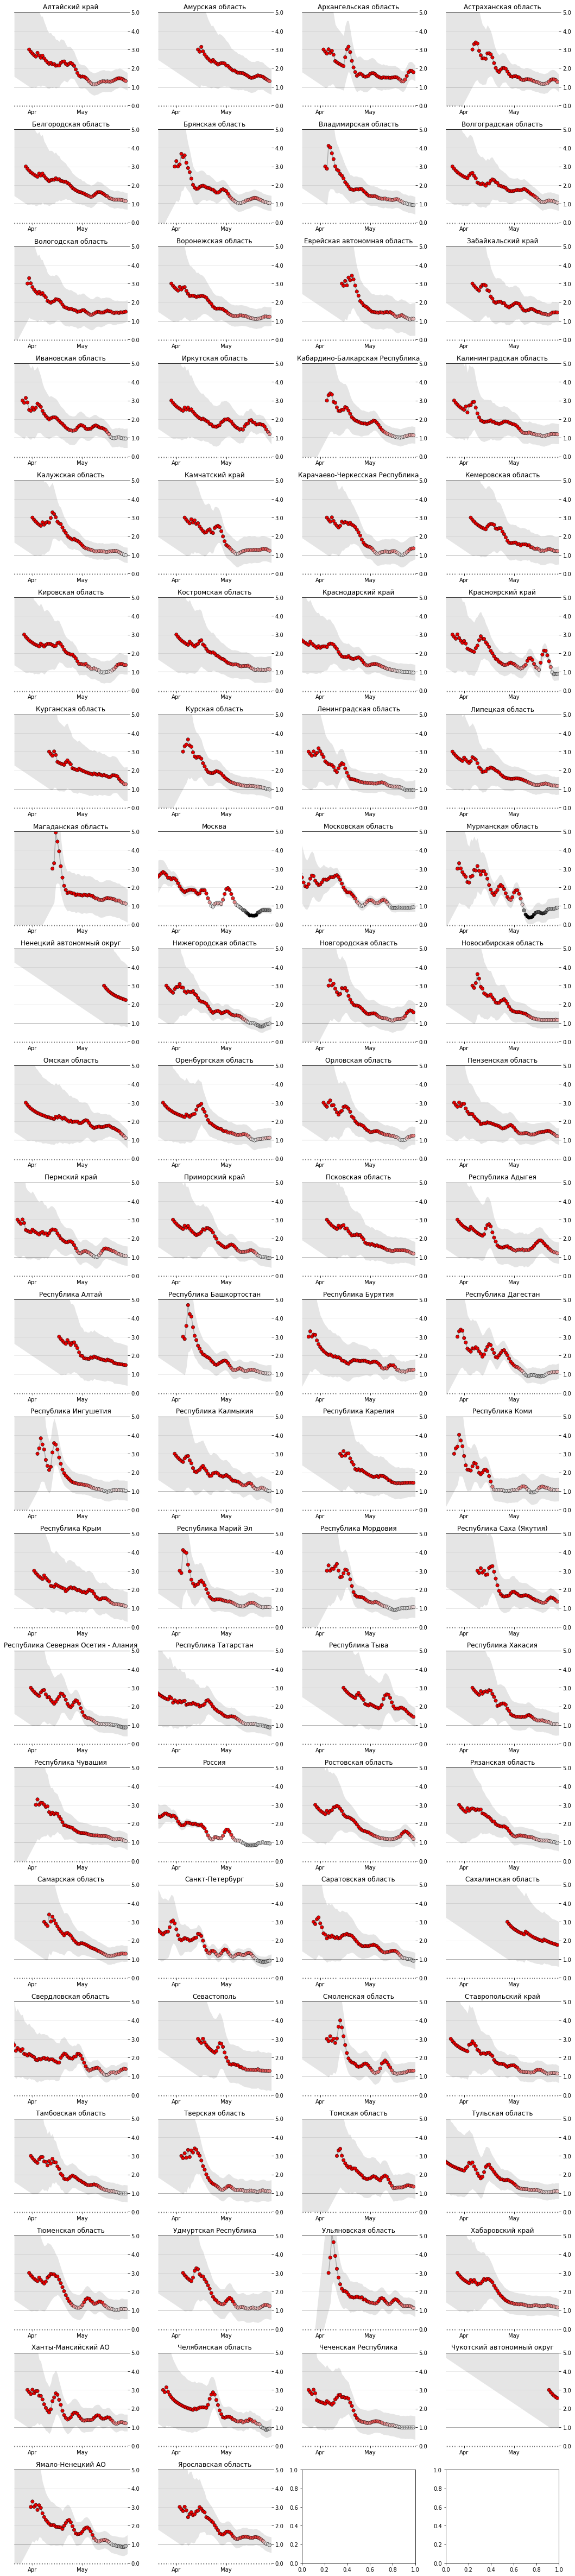

In [18]:
ncols = 4
nrows = int(np.ceil(len(rt_df.groupby('state')) / ncols))

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, nrows*3))

for i, (state_name, result) in enumerate(rt_df.groupby('state')):
    if len(result) < 2:
        print(f"Not enough data to plot: {state_name}")
        continue
    plot_rt(result.set_index('date'), axes.flat[i], state_name)

fig.tight_layout()
fig.set_facecolor('w')

# Russian data

In [19]:
# Russia data by days
day_cases = ['Day-Confirmed', 'Day-Deaths', 'Day-Recovered']
rus_sum_df = rus_df.loc[rus_df['Region/City'] != 'Diamond Princess']
rus_sum_df = rus_sum_df.groupby('Date').apply(lambda df: df[day_cases].sum())
rus_sum_df['Country/Region'] = 'Russia'
rus_sum_df = rus_sum_df.groupby('Country/Region').apply(lambda df: df[day_cases].cumsum()).reset_index()
rus_sum_df['Country/Region'] = 'Russia'
rus_sum_df = rus_sum_df.rename(columns={'Day-Confirmed': 'Confirmed', 'Day-Deaths': 'Deaths', 'Day-Recovered': 'Recovered'})

rus_sum_df['Day-Confirmed'] = rus_sum_df.groupby('Country/Region')['Confirmed'].diff()
rus_sum_df['Day-Deaths'] = rus_sum_df.groupby('Country/Region')['Deaths'].diff()
rus_sum_df['Day-Recovered'] = rus_sum_df.groupby('Country/Region')['Recovered'].diff()
rus_sum_df.loc[0, ['Day-Confirmed', 'Day-Deaths', 'Day-Recovered']] = rus_sum_df.loc[0, ['Confirmed', 'Deaths', 'Recovered']].values 

rus_sum_df['Active'] = rus_sum_df['Confirmed'] - rus_sum_df['Deaths'] - rus_sum_df['Recovered']
rus_sum_df['Death_rate'] = rus_sum_df['Deaths'] / rus_sum_df['Confirmed'] * 100

# rus_sum_df.tail()

Russia summary table

In [20]:
cm = sns.light_palette("green", as_cmap=True)
style = (rus_sum_df.drop('Country/Region', axis=1).style
         .bar(subset=['Confirmed', 'Deaths'], color='#67000d')
         .bar(subset=['Recovered'], color='#00441b')
         .background_gradient(cmap='Reds')
         .background_gradient(cmap='Greens', subset=['Day-Recovered', 'Recovered'])    
        )
style

,Date,Confirmed,Deaths,Recovered,Day-Confirmed,Day-Deaths,Day-Recovered,Active,Death_rate
0,2020-01-31 00:00:00,2,0,0,2,0,0,2,0
1,2020-02-03 00:00:00,3,0,0,1,0,0,3,0
2,2020-02-12 00:00:00,3,0,2,0,0,2,1,0
3,2020-03-05 00:00:00,4,0,2,1,0,0,2,0
4,2020-03-06 00:00:00,10,0,2,6,0,0,8,0
5,2020-03-07 00:00:00,14,0,3,4,0,1,11,0
6,2020-03-08 00:00:00,17,0,3,3,0,0,14,0
7,2020-03-09 00:00:00,20,0,3,3,0,0,17,0
8,2020-03-11 00:00:00,28,0,3,8,0,0,25,0
9,2020-03-12 00:00:00,34,0,3,6,0,0,31,0


In [21]:
temp = rus_sum_df.melt(id_vars="Date", value_vars=['Recovered', 'Deaths', 'Active'],
                 var_name='Case', value_name='Count')

fig = px.area(temp, x="Date", y="Count", color='Case',
             title='Russia situation over time', color_discrete_sequence = [rec, dth, act])

temp1 = rus_sum_df[rus_sum_df['Date'] >= pd.Timestamp('2020-03-25')]
fig.add_trace(go.Scatter(x=temp1.Date, y=temp1.Death_rate, name="Death Rate %", yaxis="y2", line_color=dth))
fig.update_layout(yaxis2=dict(overlaying="y", side="left", position=0.50))

fig.show()


In [22]:
rus_days_df = rus_sum_df[['Date', 'Country/Region', 'Confirmed', 'Deaths', 'Recovered']]
first_day = rus_days_df['Date'][0]
rus_days_df['Days'] = rus_days_df.groupby('Date').apply(lambda df: df['Date'] - first_day).reset_index(drop=True)

columns = rus_days_df.columns
threshold = rus_days_df['Confirmed'].max() + 500

def country_data(country):
    country_df = world_cases_df.loc[world_cases_df['Country/Region'] == country]
    country_df = country_df.loc[(country_df['Confirmed'] > 0) & (country_df['Confirmed'] <= threshold)].reset_index(drop=True)

    first_day = country_df['Date'][0]
    country_df['Days'] = country_df.groupby('Date').apply(lambda df: df['Date'] - first_day).reset_index(drop=True)
    country_df = country_df[columns]
    return country_df

italy_df = country_data('Italy')
spain_df = country_data('Spain')
iran_df = country_data('Iran')
germany_df = country_data('Germany')
# france_df = country_data('France')
# us_df = country_data('US')


In [23]:
temp = pd.concat([rus_days_df, italy_df, spain_df, iran_df, germany_df])

temp['Days'] = temp['Days'].astype('str')
temp1 = temp.groupby(['Country/Region', 'Date']).apply(lambda df: int(df['Days'][0].split(' ')[0])).reset_index()
temp1 = temp1.sort_values(['Date', 'Country/Region']).reset_index(drop=True)
temp = temp.sort_values(['Date', 'Country/Region']).reset_index(drop=True)
temp['Days'] = temp1[0]

fig = px.line(temp, x="Days", y="Confirmed", color='Country/Region',
              title='Comparison of the number of cases in different countries by days', height=600)
fig.update_layout(xaxis_title='Days from the first case')

fig.show()

In [24]:

rus_other_df.Date = pd.to_datetime(rus_other_df.Date, dayfirst=True)

temp = rus_other_df[rus_other_df['Date'] >= pd.Timestamp('2020-02-16')]

fig = go.Figure()
fig.add_trace(go.Scatter(x=temp.Date, y=temp.Tests,
                         line=dict(color=tst, width=2), mode='lines+markers', name='Tests performed'))
fig.update_layout(title='Number of tests performed (not number of tested people)',
                   xaxis_title='Date')
fig.show()

In [25]:
rus_tests_df = rus_other_df[rus_other_df['Date'] >= pd.Timestamp('2020-03-02')][['Date', 'Tests']]
rus_tests_df = rus_tests_df[~np.isnan(rus_tests_df.Tests)]
rus_tests_df['Day_tests'] = rus_tests_df.Tests.diff()
rus_tests_df = rus_tests_df[~np.isnan(rus_tests_df.Day_tests) & (rus_tests_df.Day_tests >= 0)]

temp = rus_sum_df[rus_sum_df['Date'] >= pd.Timestamp('2020-03-02')]

fig = go.Figure(data=[
    go.Bar(name='Day-Confirmed', x=temp.Date, y=temp['Day-Confirmed'], marker_color=cnf),
    go.Bar(name='Tests performed', x=rus_tests_df.Date, y=rus_tests_df.Day_tests, marker_color=tst)
])
# Change the bar mode
fig.update_layout(barmode='stack', yaxis_type="log", title='Tests performed and confirmed cases per day in Russia')
fig.show()

In [26]:
temp = rus_sum_df.melt(id_vars="Date", 
                 value_vars=['Day-Confirmed', 'Day-Deaths', 'Day-Recovered'])

fig = px.bar(temp, x="Date", y="value", color='variable', 
             color_discrete_sequence=[cnf, dth, rec])
fig.update_layout(barmode='group', title='New registered cases in Russia per day', yaxis_title='')
fig.show()

In [27]:
# Growth factor
def growth_factor(df):
    df['Growth-Factor'] = 1
    for i in range(1, len(df)):
        df.loc[i, 'Growth-Factor'] = df.loc[i, 'Day-Confirmed'] / df.loc[i-1, 'Day-Confirmed']
    
    df['Growth-Factor-Week'] = 1
    for i in range(7, len(df)):
        gf = 0
        for j in range(7):
            gf += df.loc[i-j, 'Day-Confirmed'] / df.loc[i-j-1, 'Day-Confirmed']
        df.loc[i, 'Growth-Factor-Week'] = gf / 7
    return df

rus_sum_df = growth_factor(rus_sum_df)

**Growth Factor**

GF = Daily-Confirmed[i] / Daily-Confirmed[i-1]

GFW = mean(GF[i-7] ... GF[i])

In [28]:
temp = rus_sum_df[rus_sum_df['Date'] >= pd.Timestamp('2020-03-1')]
temp = temp.melt(id_vars="Date", 
                 value_vars=['Growth-Factor', 'Growth-Factor-Week'])

fig = px.bar(temp, x="Date", y="value", color='variable', 
             color_discrete_sequence=[cnf, rec, dth],
             title='Growth Factor of confirmed cases in Russia')
fig.update_layout(barmode='group')
fig.add_trace(go.Scatter(x=temp['Date'], y=[1]*len(rus_sum_df),
                         line=dict(color=dth, width=4, dash='dash'), name='Inflection Level'))
fig.show()

In [29]:
def doubled(df):
    df['Doubled-Days'] = 1
    df['Incr-Fact'] = 2
    for i in reversed(range(1, len(df))):
        dd = 0
        incr = 1.0
        for j in range(1, i):
            incr = df.loc[i, 'Confirmed'] / df.loc[i-j, 'Confirmed']
            dd += 1
            if incr >= 2.0:
                break
        df.loc[i, 'Doubled-Days'] = dd
        df.loc[i, 'Incr-Fact'] = incr
    return df

rus_sum_df = doubled(rus_sum_df)

In [30]:
temp = rus_sum_df[rus_sum_df['Date'] >= pd.Timestamp('2020-03-1')]
temp = temp.melt(id_vars="Date", 
                 value_vars=['Doubled-Days', 'Incr-Fact'])

fig = px.bar(temp, x="Date", y="value", color='variable', 
             color_discrete_sequence=[cnf, dth],
             title='How long did it take for the number of total confirmed cases to double?')
fig.update_layout(barmode='group', yaxis_title='Days / Factor')
fig.show()

*Incr-Fact - increase factor between today and N days before

Simple prediction by using current Doubled-Days count and Increased-Factor. In real-world the variables constantly changing for various reasons.

In [31]:
# Prediction by current Doubled-Days and Incr-Fact
def predict(df, d_pred, reg_str='Country/Region', name_suff='Prediction'):
    # Mean values for 3 last days
    dd = int(df.iloc[-3]['Doubled-Days'].mean())
    incf = df.iloc[-1]['Incr-Fact'].mean()
    today = df.iloc[-1]['Date']
#     print(today, 'dd', dd, 'incf', incf)

    pred = df.iloc[-dd:][['Date', 'Confirmed']].reset_index(drop=True)
    for i in range(dd, d_pred + dd):
        day = pred.iloc[i - 1]['Date'] + pd.DateOffset(days=1)
        conf = pred.iloc[i - dd]['Confirmed'] * incf
        pred = pred.append(pd.DataFrame([[day, conf]], columns=pred.columns), ignore_index=True)
#         print('    ', day, conf)
    
    pred[reg_str] = df.iloc[0][reg_str] + name_suff
    return pred, dd, incf

d_pred = 14
rus_pred, dd, incf = predict(rus_sum_df, d_pred)

In [32]:
temp = pd.concat([rus_sum_df, rus_pred.iloc[dd-1:]]).reset_index(drop=True)
px.line(temp, x="Date", y="Confirmed", color='Country/Region',
        title='Prediction for {} days by current Doubled-Days({}) count and Increased-Factor({:.2})'.format(d_pred, dd, incf), height=600)

In [33]:
# Compare past predictions with current situation 
# d_pred = 28
# rus_pred1, dd, incf = predict(rus_sum_df.loc[rus_sum_df.Date <= pd.Timestamp('2020-04-08')], d_pred, name_suff='Prediction minus a week')

# temp1 = pd.concat([temp, rus_pred1.iloc[dd-1:]]).reset_index(drop=True)
# px.line(temp1, x="Date", y="Confirmed", color='Country/Region',
#         title='Prediction for {} days by current Doubled-Days({}) count and Increased-Factor({:.2})'.format(d_pred, dd, incf), height=600)

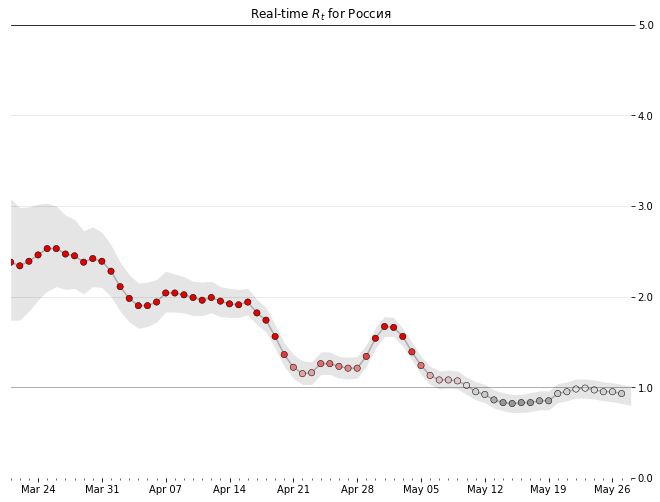

In [34]:
state_name = 'Россия'

result = rt_df.loc[rt_df.state == state_name].set_index('date')
fig, ax = plt.subplots(figsize=(800/72,600/72))
plot_rt(result, ax, state_name)
ax.set_title(f'Real-time $R_t$ for {state_name}')
ax.xaxis.set_major_locator(mdates.WeekdayLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))

In [35]:
temp = iso_df.groupby('Date')['Isol_idx'].mean().reset_index().sort_values('Date')
temp = temp.melt(id_vars="Date", 
                 value_vars=['Isol_idx'])

fig = px.bar(temp, x="Date", y="value", color='value', title='Russia Yandex self-isolation index')
fig.update_layout(barmode='group', yaxis_title='Index')

fig.show()

In [36]:
temp = rus_other_df[rus_other_df['Date'] >= pd.Timestamp('2020-02-16')]
fig = go.Figure()
fig.add_trace(go.Scatter(x=temp.Date, y=temp.Control, name='For all the period', fill='tozeroy', line_color=cnf))
fig.add_trace(go.Scatter(x=temp.Date, y=temp.Control_active, name='At given day', fill='tozeroy', line_color=act))
fig.update_layout(title='People under medical supervision',
                   xaxis_title='Date')
fig.show()

In [37]:
top = 20
# temp = rus_vent_df.head(top).sort_values('Vent_idx').melt(id_vars="Region_eng", 
#                    value_vars=['Vent_idx'])

# fig = px.bar(temp, y="Region_eng", x="value", color='variable', 
#              color_discrete_sequence=[tst, dth, rec], orientation='h')
# fig.update_layout(barmode='group', title='Ventilators per 100 000 people - Top {} region list'.format(top),
#                   xaxis_title='Index value', yaxis_title='')
# fig.show()

In [38]:
top = 20
# temp = rus_vent_df.sort_values('ECMO_idx', ascending=False).head(top).sort_values('ECMO_idx')
# temp = temp.melt(id_vars="Region_eng", value_vars=['ECMO_idx'])

# fig = px.bar(temp, y="Region_eng", x="value", color='variable', 
#              color_discrete_sequence=[dth, rec], orientation='h')
# fig.update_layout(barmode='group', title='ECMO per 100 000 people - Top {} region list'.format(top),
#                   xaxis_title='Index value', yaxis_title='')
# fig.show()

# Moscow

Moscow summary table

In [39]:
moscow_cases = rus_df.loc[rus_df['Region/City'] == 'Москва'].reset_index(drop=True)

cm = sns.light_palette("green", as_cmap=True)
style = (moscow_cases.drop(['Region/City', 'Region/City-Eng', 'Region_ID'], axis=1).style
         .bar(subset=['Confirmed', 'Deaths'], color='#67000d')
         .bar(subset=['Recovered'], color='#00441b')
         .background_gradient(cmap='Reds')
         .background_gradient(cmap='Greens', subset=['Day-Recovered', 'Recovered'])    
        )
style

,Date,Day-Confirmed,Day-Deaths,Day-Recovered,Confirmed,Deaths,Recovered,Active,Death_rate,Conf_p100k
0,2020-03-06 00:00:00,5,0,0,5,0,0,5,0,0.0393934
1,2020-03-07 00:00:00,0,0,1,5,0,1,4,0,0.0393934
2,2020-03-09 00:00:00,3,0,0,8,0,1,7,0,0.0630295
3,2020-03-11 00:00:00,6,0,0,14,0,1,13,0,0.110302
4,2020-03-12 00:00:00,4,0,0,18,0,1,17,0,0.141816
5,2020-03-13 00:00:00,5,0,0,23,0,1,22,0,0.18121
6,2020-03-14 00:00:00,9,0,0,32,0,1,31,0,0.252118
7,2020-03-16 00:00:00,20,0,0,52,0,1,51,0,0.409692
8,2020-03-17 00:00:00,3,0,0,55,0,1,54,0,0.433328
9,2020-03-18 00:00:00,31,0,0,86,0,1,85,0,0.677567


In [40]:
temp = moscow_cases.melt(id_vars="Date", 
                 value_vars=['Day-Confirmed', 'Day-Deaths', 'Day-Recovered'])

fig = px.bar(temp, x="Date", y="value", color='variable', 
             color_discrete_sequence=[cnf, dth, rec])
fig.update_layout(barmode='group', title='New registered cases in Moscow per day', yaxis_title='')
fig.show()

In [41]:
temp = moscow_cases.groupby('Date')['Recovered', 'Deaths', 'Active'].sum().reset_index()
temp = temp.melt(id_vars="Date", value_vars=['Recovered', 'Deaths', 'Active'],
                 var_name='Case', value_name='Count')
temp.head()

fig = px.area(temp, x="Date", y="Count", color='Case',
             title='Moscow cases over time', color_discrete_sequence = [rec, dth, act])

temp1 = moscow_cases[moscow_cases['Date'] >= pd.Timestamp('2020-03-25')]
fig.add_trace(go.Scatter(x=temp1.Date, y=temp1.Death_rate, name="Death Rate %", yaxis="y2", line_color=dth))
fig.update_layout(yaxis2=dict(overlaying="y", side="left", position=0.27))

fig.show()

In [42]:
# Growth factor
moscow_cases = growth_factor(moscow_cases)

temp = moscow_cases[moscow_cases['Date'] >= pd.Timestamp('2020-03-1')]
temp = temp.melt(id_vars="Date", 
                 value_vars=['Growth-Factor', 'Growth-Factor-Week'])

fig = px.bar(temp, x="Date", y="value", color='variable', 
             color_discrete_sequence=[cnf, rec, dth],
             title='Growth Factor of confirmed cases in Moscow')
fig.update_layout(barmode='group')
fig.add_trace(go.Scatter(x=temp['Date'], y=[1]*len(rus_sum_df),
                         line=dict(color=dth, width=4, dash='dash'), name='Inflection Level'))
fig.show()

In [43]:
moscow_cases = doubled(moscow_cases)

temp = moscow_cases[moscow_cases['Date'] >= pd.Timestamp('2020-03-1')]
temp = temp.melt(id_vars="Date", 
                 value_vars=['Doubled-Days', 'Incr-Fact'])

fig = px.bar(temp, x="Date", y="value", color='variable', 
             color_discrete_sequence=[cnf, dth],
             title='How long did it take for the number of total confirmed cases to double?')
fig.update_layout(barmode='group', yaxis_title='Days / Factor')
fig.show()

In [44]:
d_pred = 14
moscow_pred, dd, incf = predict(moscow_cases, d_pred, 'Region/City-Eng')

temp = pd.concat([moscow_cases, moscow_pred.iloc[dd-1:]]).reset_index(drop=True)
px.line(temp, x="Date", y="Confirmed", color='Region/City-Eng',
        title='Prediction for {} days by current Doubled-Days({}) count and Increased-Factor({:.2})'.format(d_pred, dd, incf), height=600)

**Estimated Moscow COVID-19's  Rt  in Real-Time** 
* [Detailed description](https://www.kaggle.com/fo2rist/estimating-covid-19-rt-in-real-time-russia)

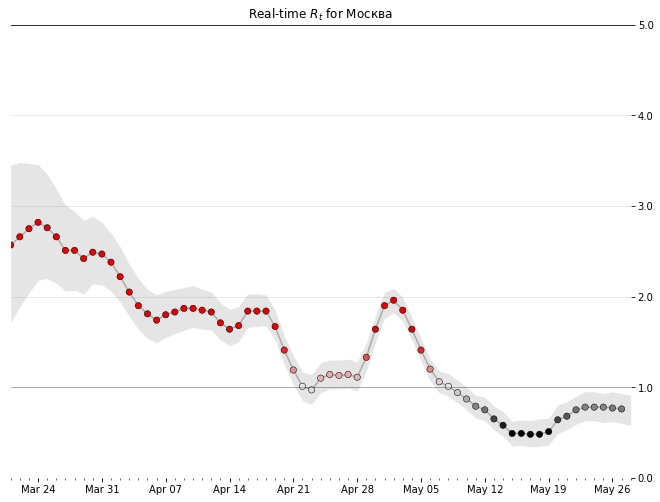

In [45]:
state_name = 'Москва'

result = rt_df.loc[rt_df.state == state_name].set_index('date')
fig, ax = plt.subplots(figsize=(800/72,600/72))
plot_rt(result, ax, state_name)
ax.set_title(f'Real-time $R_t$ for {state_name}')
ax.xaxis.set_major_locator(mdates.WeekdayLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))

[Yandex self-isolation index](https://yandex.ru/company/researches/2020/podomam) -- [Map](https://yandex.ru/maps/covid19/isolation?ll=81.460685%2C55.691496&z=4)

In [46]:
temp = iso_df[iso_df.City == 'Москва'][['Date', 'Isol_idx']].sort_values('Date')
temp = temp.melt(id_vars="Date", 
                 value_vars=['Isol_idx'])

fig = px.bar(temp, x="Date", y="value", color='value', title='Moscow Yandex self-isolation index')
fig.update_layout(barmode='group', yaxis_title='Index')

fig.show()

Additional mortality = (Deaths for current month) - mean(Values of deaths for current month per 5 previous years)

In [47]:
# Moscow deaths March-May
mos_month_deaths = {}
mos_mean_deaths = {}
mos_add_deaths = {}
for i in range(4, 5):
    mos_month_deaths[i] = rus_df.loc[(rus_df['Region/City'] != 'Москва') &
                              (rus_df.Date >= pd.Timestamp(f'2020-{i}-1')) &
                              (rus_df.Date < pd.Timestamp(f'2020-{i+1}-1'))
                              , 'Day-Deaths'].sum()
    
    mos_mean_deaths[i] = mos_death_df.loc[(mos_death_df.Month == i) & (mos_death_df.Year >= 2015) & (mos_death_df.Year <= 2019), 'Deaths'].mean()
    mos_add_deaths[i] = mos_death_df.loc[(mos_death_df.Month == i) & (mos_death_df.Year == 2020), 'Deaths'].values[0] - mos_mean_deaths[i]

# print(mos_month_deaths)
# print(mos_mean_deaths)
# print(mos_add_deaths)

temp = pd.DataFrame([mos_month_deaths, mos_mean_deaths, mos_add_deaths]).transpose()
temp.columns = ['Covid', 'Mean', 'Add']
temp['Unknown'] = temp.Add - temp.Covid
temp.Unknown = temp.Unknown.astype('int')

fig = go.Figure(data=[
    go.Bar(name='COVID-19 deaths', x=temp.index, y=temp.Covid, text=temp.Covid, textposition='auto', marker_color=cnf),
    go.Bar(name='Unknown reason', x=temp.index, y=temp.Unknown,  text=temp.Unknown, textposition='auto', marker_color=dth)
])
# Change the bar mode
fig.update_layout(barmode='stack', title='Additional mortality in Moscow', xaxis_title='Month')
fig.show()

# Regions without Moscow and Moscow region

In [48]:
reg_sum_df = rus_df.loc[(rus_df['Region/City'] != 'Москва') & (rus_df['Region/City'] != 'Московская область')].reset_index(drop=True)

# Regions data by days
reg_sum_df = reg_sum_df.groupby('Date').apply(lambda df: df[day_cases].sum())
reg_sum_df['Country/Region'] = 'Russia regions'
reg_sum_df = reg_sum_df.groupby('Country/Region').apply(lambda df: df[day_cases].cumsum()).reset_index()
reg_sum_df['Country/Region'] = 'Russia regions'
reg_sum_df = reg_sum_df.rename(columns={'Day-Confirmed': 'Confirmed', 'Day-Deaths': 'Deaths', 'Day-Recovered': 'Recovered'})

reg_sum_df['Day-Confirmed'] = reg_sum_df.groupby('Country/Region')['Confirmed'].diff()
reg_sum_df['Day-Deaths'] = reg_sum_df.groupby('Country/Region')['Deaths'].diff()
reg_sum_df['Day-Recovered'] = reg_sum_df.groupby('Country/Region')['Recovered'].diff()
reg_sum_df.loc[0, ['Day-Confirmed', 'Day-Deaths', 'Day-Recovered']] = reg_sum_df.loc[0, ['Confirmed', 'Deaths', 'Recovered']].values 

reg_sum_df['Active'] = reg_sum_df['Confirmed'] - reg_sum_df['Deaths'] - reg_sum_df['Recovered']
reg_sum_df['Death_rate'] = reg_sum_df['Deaths'] / reg_sum_df['Confirmed'] * 100

region_name = 'Russia province regions'

# reg_sum_df.tail()

In [49]:

cm = sns.light_palette("green", as_cmap=True)
style = (reg_sum_df.drop(['Country/Region'], axis=1).style
         .bar(subset=['Confirmed', 'Deaths'], color='#67000d')
         .bar(subset=['Recovered'], color='#00441b')
         .background_gradient(cmap='Reds')
         .background_gradient(cmap='Greens', subset=['Day-Recovered', 'Recovered'])    
        )
style

,Date,Confirmed,Deaths,Recovered,Day-Confirmed,Day-Deaths,Day-Recovered,Active,Death_rate
0,2020-01-31 00:00:00,2,0,0,2,0,0,2,0
1,2020-02-12 00:00:00,2,0,2,0,0,2,0,0
2,2020-03-05 00:00:00,3,0,2,1,0,0,1,0
3,2020-03-06 00:00:00,4,0,2,1,0,0,2,0
4,2020-03-07 00:00:00,8,0,2,4,0,0,6,0
5,2020-03-08 00:00:00,10,0,2,2,0,0,8,0
6,2020-03-12 00:00:00,12,0,2,2,0,0,10,0
7,2020-03-13 00:00:00,17,0,2,5,0,0,15,0
8,2020-03-14 00:00:00,21,0,2,4,0,0,19,0
9,2020-03-15 00:00:00,22,0,2,1,0,0,20,0


In [50]:
temp = reg_sum_df.melt(id_vars="Date", 
                 value_vars=['Day-Confirmed', 'Day-Deaths', 'Day-Recovered'])

fig = px.bar(temp, x="Date", y="value", color='variable', 
             color_discrete_sequence=[cnf, dth, rec])
fig.update_layout(barmode='group', title=f'New registered cases in {region_name} per day', yaxis_title='')
fig.show()

In [51]:
temp = reg_sum_df.groupby('Date')['Recovered', 'Deaths', 'Active'].sum().reset_index()
temp = temp.melt(id_vars="Date", value_vars=['Recovered', 'Deaths', 'Active'],
                 var_name='Case', value_name='Count')
temp.head()

fig = px.area(temp, x="Date", y="Count", color='Case',
             title=f'{region_name} cases over time', color_discrete_sequence = [rec, dth, act])

temp1 = reg_sum_df[reg_sum_df['Date'] >= pd.Timestamp('2020-03-28')]
fig.add_trace(go.Scatter(x=temp1.Date, y=temp1.Death_rate, name="Death Rate %", yaxis="y2", line_color=dth))
fig.update_layout(yaxis2=dict(overlaying="y", side="left", position=0.50))

fig.show()

In [52]:
# Growth factor
reg_sum_df = growth_factor(reg_sum_df)

temp = reg_sum_df[reg_sum_df['Date'] >= pd.Timestamp('2020-03-1')]
temp = temp.melt(id_vars="Date", 
                 value_vars=['Growth-Factor', 'Growth-Factor-Week'])

fig = px.bar(temp, x="Date", y="value", color='variable', 
             color_discrete_sequence=[cnf, rec, dth],
             title=f'Growth Factor of confirmed cases in {region_name}')
fig.update_layout(barmode='group')
fig.add_trace(go.Scatter(x=temp['Date'], y=[1]*len(rus_sum_df),
                         line=dict(color=dth, width=4, dash='dash'), name='Inflection Level'))
fig.show()

In [53]:
reg_sum_df = doubled(reg_sum_df)

temp = reg_sum_df[reg_sum_df['Date'] >= pd.Timestamp('2020-03-1')]
temp = temp.melt(id_vars="Date", 
                 value_vars=['Doubled-Days', 'Incr-Fact'])

fig = px.bar(temp, x="Date", y="value", color='variable', 
             color_discrete_sequence=[cnf, dth],
             title='How long did it take for the number of total confirmed cases to double?')
fig.update_layout(barmode='group', yaxis_title='Days / Factor')
fig.show()